In [93]:
import numpy as np 
import pandas as pd
from numpy import ndarray
from sklearn.datasets import load_diabetes 
import matplotlib.pyplot as plt

from typing import Callable, Dict, Tuple, List



In [94]:

boston = load_diabetes()

data = boston.data
target = boston.target
features = boston.feature_names



In [ ]:

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(data, target, test_size=0.3, random_state=80718)

y_train, y_test = y_train.reshape(-1, 1), y_test.reshape(-1, 1)

In [96]:
from sklearn.preprocessing import StandardScaler
s = StandardScaler()
data = s.fit_transform(data)

In [97]:
def forward_linear_regression(X_batch: ndarray,
                              y_batch: ndarray,
                              weights: Dict[str, ndarray]
                              )-> Tuple[float, Dict[str, ndarray]]:
    '''
    Forward pass for the step-by-step linear regression.
    '''
    # assert batch sizes of X and y are equal
    assert X_batch.shape[0] == y_batch.shape[0]

    # assert that matrix multiplication can work
    assert X_batch.shape[1] == weights['W'].shape[0]

    # assert that B is simply a 1x1 ndarray
    assert weights['B'].shape[0] == weights['B'].shape[1] == 1

    # compute the operations on the forward pass
    N = np.dot(X_batch, weights['W'])

    P = N + weights['B']

    loss = np.mean(np.power(y_batch - P, 2))

    # save the information computed on the forward pass
    forward_info: Dict[str, ndarray] = {}
    forward_info['X'] = X_batch
    forward_info['N'] = N
    forward_info['P'] = P
    forward_info['y'] = y_batch

    return loss, forward_info


In [98]:

def to_2d_np(a: ndarray, 
             type: str = "col") -> ndarray:
    '''
    Turns a 1D Tensor into 2D
    '''

    assert a.ndim == 1, \
    "Input tensors must be 1 dimensional"
    
    if type == "col":        
        return a.reshape(-1, 1)
    elif type == "row":
        return a.reshape(1, -1)

In [99]:
def permute_data(X: ndarray, y: ndarray):
    '''
    Permute X and y, using the same permutation, along axis=0
    '''
    perm = np.random.permutation(X.shape[0])
    return X[perm], y[perm]

In [100]:

def loss_gradients(forward_info: Dict[str, ndarray],
                   weights: Dict[str, ndarray]) -> Dict[str, ndarray]:
    '''
    Compute dLdW and dLdB for the step-by-step linear regression model.
    '''
    batch_size = forward_info['X'].shape[0]

    dLdP = -2 * (forward_info['y'] - forward_info['P'])

    dPdN = np.ones_like(forward_info['N'])

    dPdB = np.ones_like(weights['B'])

    dLdN = dLdP * dPdN

    dNdW = np.transpose(forward_info['X'], (1, 0))
    
    # need to use matrix multiplication here,
    # with dNdW on the left (see note at the end of last chapter)    
    dLdW = np.dot(dNdW, dLdN)

    # need to sum along dimension representing the batch size:
    # see note near the end of the chapter    
    dLdB = (dLdP * dPdB).sum(axis=0)

    loss_gradients: Dict[str, ndarray] = {}
    loss_gradients['W'] = dLdW
    loss_gradients['B'] = dLdB

    return loss_gradients

In [101]:

Batch = Tuple[ndarray, ndarray]

def generate_batch(X: ndarray, 
                   y: ndarray,
                   start: int = 0,
                   batch_size: int = 10) -> Batch:
    '''
    Generate batch from X and y, given a start position
    '''
    assert X.ndim == y.ndim == 2, \
    "X and Y must be 2 dimensional"

    if start+batch_size > X.shape[0]:
        batch_size = X.shape[0] - start
    
    X_batch, y_batch = X[start:start+batch_size], y[start:start+batch_size]
    
    return X_batch, y_batch

In [102]:

def forward_loss(X: ndarray,
                 y: ndarray,
                 weights: Dict[str, ndarray]) -> Tuple[Dict[str, ndarray], float]:
    '''
    Generate predictions and calculate loss for a step-by-step linear regression
    (used mostly during inference).
    '''
    N = np.dot(X, weights['W'])

    P = N + weights['B']

    loss = np.mean(np.power(y - P, 2))

    forward_info: Dict[str, ndarray] = {}
    forward_info['X'] = X
    forward_info['N'] = N
    forward_info['P'] = P
    forward_info['y'] = y

    return forward_info, loss

In [103]:

def init_weights(n_in: int) -> Dict[str, ndarray]:
    '''
    Initialize weights on first forward pass of model.
    '''
    
    weights: Dict[str, ndarray] = {}
    W = np.random.randn(n_in, 1)
    B = np.random.randn(1, 1)
    
    weights['W'] = W
    weights['B'] = B

    return weights

In [104]:

def train(X: ndarray, 
          y: ndarray, 
          n_iter: int = 1000,
          learning_rate: float = 0.01,
          batch_size: int = 100,
          return_losses: bool = False, 
          return_weights: bool = False, 
          seed: int = 1) -> None:
    '''
    Train model for a certain number of epochs.
    '''
    if seed:
        np.random.seed(seed)
    start = 0

    # Initialize weights
    weights = init_weights(X.shape[1])

    # Permute data
    X, y = permute_data(X, y)
    
    if return_losses:
        losses = []

    for i in range(n_iter):

        # Generate batch
        if start >= X.shape[0]:
            X, y = permute_data(X, y)
            start = 0
        
        X_batch, y_batch = generate_batch(X, y, start, batch_size)
        start += batch_size
    
        # Train net using generated batch
        forward_info, loss = forward_loss(X_batch, y_batch, weights)

        if return_losses:
            losses.append(loss)

        loss_grads = loss_gradients(forward_info, weights)
        for key in weights.keys():
            weights[key] -= learning_rate * loss_grads[key]

    if return_weights:
        return losses, weights
    
    return None

In [105]:
train_info = train(X_train, y_train,
                   n_iter = 1000,
                   learning_rate = 0.001,
                   batch_size=23, 
                   return_losses=True, 
                   return_weights=True, 
                   seed=180708)
losses = train_info[0]
weights = train_info[1]

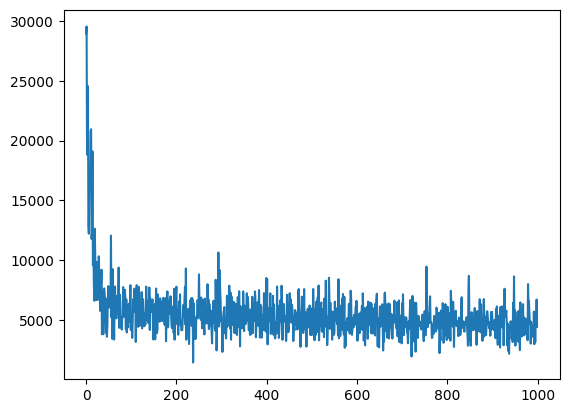

In [106]:

plt.plot(list(range(1000)), losses);

In [107]:
def predict(X: ndarray,
            weights: Dict[str, ndarray]):
    '''
    Generate predictions from the step-by-step linear regression model.
    '''

    N = np.dot(X, weights['W'])

    return N + weights['B']

In [108]:
def mae(preds: ndarray, actuals: ndarray):
    '''
    Compute mean absolute error.
    '''
    return np.mean(np.abs(preds - actuals))

def rmse(preds: ndarray, actuals: ndarray):
    '''
    Compute root mean squared error.
    '''
    return np.sqrt(np.mean(np.power(preds - actuals, 2)))

In [109]:
preds = predict(X_test, weights)

print("Mean absolute error:", round(mae(preds, y_test), 4), "\n"
      "Root mean squared error:", round(rmse(preds, y_test), 4))


np.round(y_test.mean(), 4)

np.round(rmse(preds, y_test) / y_test.mean(), 4)

Mean absolute error: 61.0929 
Root mean squared error: 69.5702


0.4502

In [120]:

np.round(y_test.mean(), 4)


np.round(rmse(preds, y_test) / y_test.mean(), 4)


0.4502

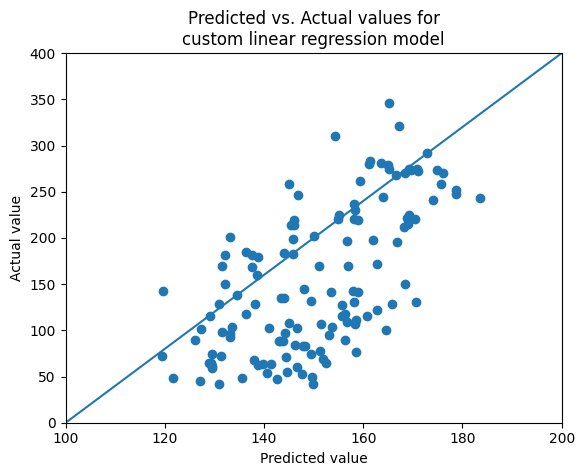

In [116]:
plt.xlabel("Predicted value")
plt.ylabel("Actual value")
plt.title("Predicted vs. Actual values for\ncustom linear regression model");
plt.xlim([100, 200])
plt.ylim([0, 400])
plt.scatter(preds, y_test)
plt.plot([100, 200], [0, 400]);